In [8]:
import pandas as pd
from PIL import Image
import requests
from tqdm.auto import tqdm
from transformers import CLIPProcessor, CLIPModel
import torch
import matplotlib.pyplot as plt
from io import BytesIO
import os


In [2]:
# Loading the photos file from the directory
df_photos = pd.read_csv("tmp/photos.tsv000", sep='\t')

# Select only the relevant columns
df_photos = df_photos[['photo_id', 'photo_image_url']]

# Display the DataFrame
df_photos

,photo_id,photo_image_url
0,bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...
1,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...
2,grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...
3,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...
4,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...
...,...,...
24995,rZQq3bdOsJU,https://images.unsplash.com/photo-159220387694...
24996,swQ3JS8e-Fs,https://images.unsplash.com/photo-159186159766...
24997,pZroun8cH1w,https://images.unsplash.com/photo-159256175999...
24998,JqOvq9ypB4w,https://images.unsplash.com/photo-159191191322...


In [3]:
# Load the CLIP model and processor
model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

def extract_image_features(image):
    # Process the image using CLIP processor
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
    return outputs.squeeze().tolist()

def create_embeddings(image=None, text=None):
    # Initialize embeddings
    image_embeddings = None
    text_embeddings = None
    
    # Process the image if provided
    if image is not None:
        image_embeddings = extract_image_features(image)
        image_embeddings = torch.tensor(image_embeddings)
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    # Process the text if provided
    if text is not None:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True)
        with torch.no_grad():
            text_outputs = model.get_text_features(**text_inputs)
            text_embeddings = text_outputs / text_outputs.norm(dim=-1, keepdim=True)
            text_embeddings = text_embeddings.squeeze(0).tolist()

    # Combine the embeddings if both image and text are provided, and normalize
    if image_embeddings is not None and text_embeddings is not None:
        combined_embeddings = (image_embeddings + torch.tensor(text_embeddings)) / 2
        combined_embeddings = combined_embeddings / combined_embeddings.norm(dim=-1, keepdim=True)
        return combined_embeddings.tolist()

    # Return only image or text embeddings if one of them is provided
    return image_embeddings.tolist() if text_embeddings is None else text_embeddings

# Get the first 1000 images
photo_ids = df_photos['photo_id'][:1000]
df_photos = df_photos.loc[photo_ids.index, ['photo_id', 'photo_image_url']]

# Create a session to make HTTP requests
session = requests.Session()

# Define the function to download and get embeddings
def process_image(url):
    try:
        # Make a GET request to download the image
        response = session.get(url, stream=True)
        response.raise_for_status()
        image = Image.open(response.raw)
        # Get the embeddings and return
        return create_embeddings(image)
    except requests.RequestException:
        return None

# Construct a URL to download the image with a smaller size
df_photos['photo_image_url'] = df_photos['photo_image_url'].apply(lambda x: x + "?q=75&fm=jpg&w=200&fit=max")

# Pass the images one by one to the 'process_image' and save the embeddings to the newly created column 'photo_embed'
df_photos['photo_embed'] = [process_image(url) for url in tqdm(df_photos['photo_image_url'], total=len(df_photos))]

# Remove rows where image processing failed
df_photos.dropna(subset=['photo_embed'], inplace=True)

# Reset the index and rename the 'id' column to 'index'
df_photos = df_photos[df_photos['photo_id'].isin(photo_ids)].reset_index().rename(columns={'index': 'id'})

# Close the session
session.close()

c:\Users\tohfa\anaconda3\envs\Image_Retriever\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
df_photos

,id,photo_id,photo_image_url,photo_embed
0,0,bygTaBey1Xk,https://images.unsplash.com/uploads/1413387620...,"[0.003251494839787483, -0.009108160622417927, ..."
1,1,gXSFnk2a9V4,https://images.unsplash.com/reserve/jEs6K0y1Sb...,"[0.009691603481769562, 0.007062951102852821, -..."
2,2,grg6-DNJuaU,https://images.unsplash.com/uploads/1412192004...,"[0.012407696805894375, 0.026625679805874825, -..."
3,3,sO42hhChB1c,https://images.unsplash.com/reserve/ijl3tATFRp...,"[0.0029382500797510147, 0.009468013420701027, ..."
4,4,tkk8_HakQ98,https://images.unsplash.com/reserve/6vaWXsQuSW...,"[-0.04261797294020653, -0.015577106736600399, ..."
...,...,...,...,...
995,995,7wmi235GscY,https://images.unsplash.com/photo-147041800180...,"[-0.0394107922911644, 0.049085743725299835, 0...."
996,996,kcolRj9wnec,https://images.unsplash.com/photo-147187382162...,"[0.009193161502480507, 6.291930912993848e-05, ..."
997,997,34pAD9-7Rb8,https://images.unsplash.com/photo-147016666846...,"[0.015186621807515621, 0.009206265211105347, 0..."
998,998,itdkHUjTuIY,https://images.unsplash.com/photo-147470434644...,"[-0.01294940710067749, 0.042597439140081406, 0..."


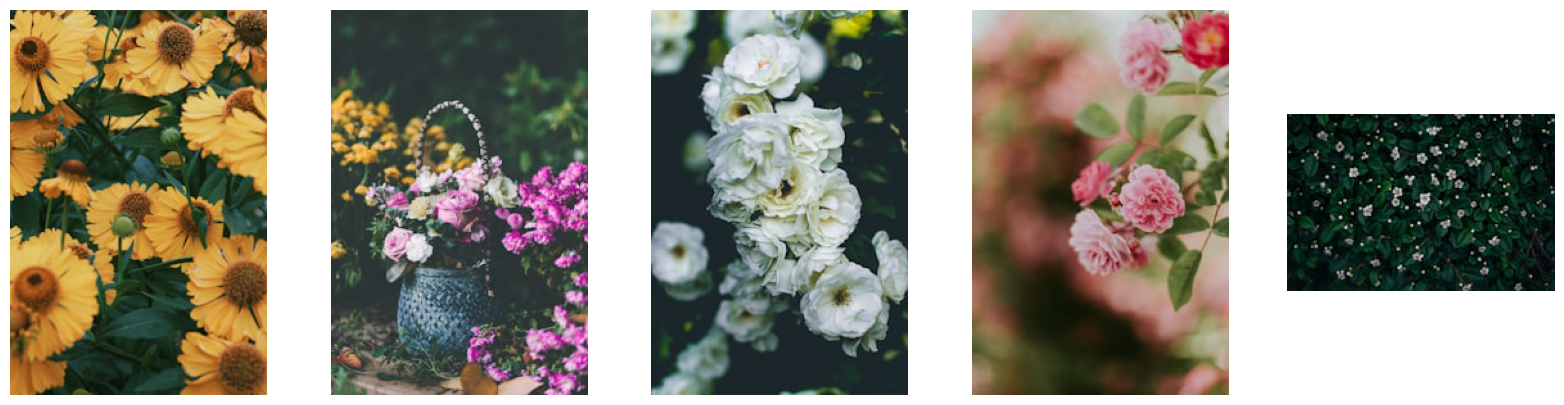

NameError: name 'os' is not defined

In [9]:
# Assuming your CSV has columns 'photo_image_url' and 'photo_embed'
image_urls = df_photos['photo_image_url'].tolist()
embeddings = torch.tensor(df_photos['photo_embed'].tolist())  # Adjust based on your actual format

# Function to search for relevant images given a prompt
def search_images(prompt, image_urls, embeddings, top_k=5):
    # Preprocess the prompt to create embeddings
    inputs = processor(text=[prompt], return_tensors="pt", padding=True)
    prompt_features = model.get_text_features(**inputs)
    
    # Compute cosine similarity between the prompt and precomputed image embeddings
    similarities = torch.nn.functional.cosine_similarity(prompt_features, embeddings)
    
    # Get the top k most similar images
    top_k_indices = similarities.topk(k=top_k).indices
    
    # Retrieve the image URLs and their similarity scores
    results = [(image_urls[idx], similarities[idx].item()) for idx in top_k_indices]
    
    return results

# Function to download images
def download_images(results, download_folder="downloaded_images"):
    # Create the download folder if it doesn't exist
    os.makedirs(download_folder, exist_ok=True)
    
    for idx, (image_url, score) in enumerate(results):
        try:
            # Download the image
            response = requests.get(image_url)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))
                
                # Define the file path
                file_path = os.path.join(download_folder, f"image_{idx + 1}.jpg")
                
                # Save the image
                image.save(file_path)
                print(f"Downloaded: {file_path}")
            else:
                print(f"Failed to download image from {image_url}. Status code: {response.status_code}")
        except Exception as e:
            print(f"Error processing {image_url}: {e}")

# Example usage
prompt = input("Please enter a search prompt (e.g., 'Pictures of animals'): ")
results = search_images(prompt, image_urls, embeddings, top_k=5)

# Display the results
fig, axes = plt.subplots(1, len(results), figsize=(20, 5))
for ax, (image_url, score) in zip(axes, results):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    ax.imshow(image)
    ax.axis('off')

plt.show()

# Call the download function after displaying images
download_images(results)
